In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# "Computs" center of "mass" for radial bins
def calc_rad(dat):
    # TODO Something is wrong here
    # starts at 0, didn't it start at 4?
    rad1,counts = np.unique(dat[:,0], return_counts=True)
    rad2 = np.unique(dat[:,1])
    rad = rad2-(rad2-rad1)/2.0
    counts = counts[0]
    return rad,counts
    

def Coord_Get(fl_in):
    '''
    Function to determine the radius and theta matrix
    plt_size is dependent on the size of the membrane plotted
    *** plt_size is no longer used remove ***
    
    dr, dth, theta, radius = Coord_Get(50)
    '''
    dat = np.loadtxt(fl_in, skiprows=1)
    Ntheta = np.shape(dat)[1]-4
    frames = 1
    #rad = dat[:,1]+(dat[:,1]-dat[:,0])/2.0    
    rad, frames = calc_rad(dat)
    dr = rad[1]-rad[0]
    the = np.linspace(0,2*np.pi,Ntheta)
    dth = the[1]-the[0]
    theta,radius=np.meshgrid(the,rad)

    return rad, dr, dth, theta, radius, frames, Ntheta

def get_header_info(fpath):
    '''
    Parameters
    ----------
    sat_files : str
        path to a data file. extracts extra information
        used for analysis

    Returns
    -------
    list
        Number of molecules, number of beads per mol, and expected
        density.
    '''
    line = open(fpath,'r').readline()
    num_mol = float(line.split(",")[0].split(":")[1].split(" ")[1])
    beads = float(line.split(",")[1].split(":")[1].split(" ")[1])
    avg_A = float(line.split(',')[2].split(":")[1].split(" ")[1])
    exrho = float(line.split(",")[3].split(":")[1].split("/")[0])
    avg_chain = float(line.split(",")[4].split(":")[1].split(" ")[1])
    return num_mol,avg_A,beads,exrho,avg_chain

def get_dg(densities, Npeak, RT= 0.6427483):
    p_lessthan = np.sum(densities[:int(Npeak)])
    p_greaterthan = np.sum(densities[int(Npeak):])
    dG = -RT*np.log(p_greaterthan/p_lessthan)
    return dG

In [3]:
lipid = "POPG"
leaf = "upp"
data_root = Path("/Users/ezry/Projects/ELIC_PE_PG/trajectory_version/")
fpath = data_root.joinpath(f"{lipid}.dat.{leaf}.dat")

In [4]:
num_mol,avg_A,beads,exrho,avg_chain = get_header_info(fpath)
the_data = np.loadtxt(fpath, skiprows=1)
rad, dr, dth, theta, radius, frames, Ntheta = Coord_Get(fpath)


In [5]:
def get_shell(some_data, inner_radius, outer_radius, frames, Ntheta, dr):
    mask = np.logical_and(some_data[:,0] >= inner_radius, some_data[:,1] <= outer_radius)
    meta_shell = some_data[mask, 3:-1]
    nshells = (outer_radius-inner_radius)/dr
    assert nshells == int(nshells), "Error: non-integer number of shells"
    reshaped = np.reshape(meta_shell, (int(nshells),frames, Ntheta))
    flattened = np.sum(reshaped, axis=0)
    return flattened

In [6]:
def plot_density(densities, Nexpected, experimental_mean):
    fig, ax = plt.subplots()

    dG = get_dg(densities, Nexpected)

    ax.vlines(Nexpected, 0, np.max(densities), color='k', linestyles='dashed', label="expected mean")
    ax.vlines(experimental_mean, 0, np.max(densities), color='red', linestyles='solid', label="actual mean")
    ax.plot(np.arange(len(densities)), densities, label=r"$\Delta G =$"+f"{np.round(dG,2)}kcal/mol")

    ax.legend()
    ax.set_xlabel(r"$N_\mathrm{beads}$")
    ax.set_ylabel("Probability Density")

    return fig, ax

In [7]:
def get_site_stats(site, site_area, exrho):
    frequencies = np.bincount(site.astype(int).flatten())
    densities = frequencies/np.sum(frequencies)
    
    Nexpected = exrho*site_area
    experimental_mean = np.mean(site)
    return densities, Nexpected, experimental_mean

In [8]:
def get_area(inner_r, outer_r, dth, thetabins):
    return np.mean([inner_r, outer_r])*(outer_r-inner_r)*dth*thetabins

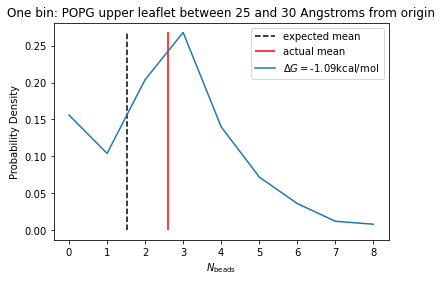

In [9]:
inner_r = 25
outer_r = 30
test_shell = get_shell(the_data, inner_r, outer_r, frames, Ntheta, dr)
the_thetas = [29]
thetabins = 1
site = test_shell[:,the_thetas]


site_area = get_area(inner_r, outer_r, dth, thetabins)
densities, Nexpected, experimental_mean = get_site_stats(site, site_area, exrho)
fig, ax = plot_density(densities, Nexpected, experimental_mean, inner_r, outer_r)
ax.set_title(f"One bin: {lipid} {leaf}er leaflet between {inner_r} and {outer_r} Angstroms from origin")

plt.savefig(f"one_bin_site_{lipid}_{leaf}.pdf")

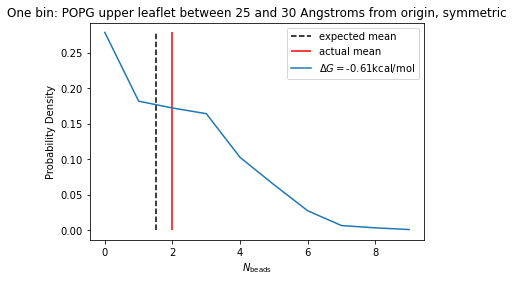

In [10]:
inner_r = 25
outer_r = 30
test_shell = get_shell(the_data, inner_r, outer_r, frames, Ntheta, dr)
the_thetas = np.arange(5,30,6)
ntheta = 1 #because we're using "replicas"
site = test_shell[:,the_thetas]

site_area = get_area(inner_r, outer_r, dth, ntheta)
densities, Nexpected, experimental_mean = get_site_stats(site, site_area, exrho)
fig, ax = plot_density(densities, Nexpected, experimental_mean, inner_r, outer_r)
ax.set_title(f"One bin: {lipid} {leaf}er leaflet between {inner_r} and {outer_r} Angstroms from origin, symmetric")

plt.savefig(f"one_bin_symmetric_{lipid}_{leaf}.pdf")

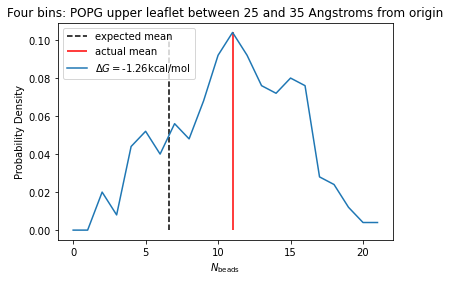

In [11]:
inner_r = 25
outer_r = 35
test_shell = get_shell(the_data, inner_r, outer_r, frames, Ntheta, dr)
the_thetas = np.arange(28,30,1)
site = np.sum(test_shell[:,the_thetas], axis=1)

ntheta = 2
site_area = get_area(inner_r, outer_r, dth, ntheta)
densities, Nexpected, experimental_mean = get_site_stats(site, site_area, exrho)
fig, ax = plot_density(densities, Nexpected, experimental_mean, inner_r, outer_r)
ax.set_title(f"Four bins: {lipid} {leaf}er leaflet between {inner_r} and {outer_r} Angstroms from origin")

plt.savefig(f"four_bins_{lipid}_{leaf}.pdf")

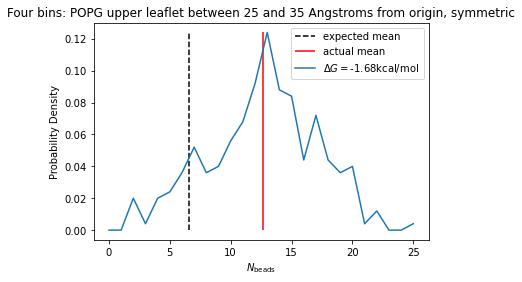

In [12]:
inner_r = 25
outer_r = 35
large_shell = get_shell(the_data, inner_r, outer_r, frames, Ntheta, dr)
small_shell = get_shell(the_data, 20, 25, frames, Ntheta, dr)
site = np.sum(large_shell[:,28:30], axis=1)+small_shell[:,28]

ntheta = 2
site_area = get_area(inner_r, outer_r, dth, ntheta)
densities, Nexpected, experimental_mean = get_site_stats(site, site_area, exrho)
fig, ax = plot_density(densities, Nexpected, experimental_mean, inner_r, outer_r)
ax.set_title(f"Four bins: {lipid} {leaf}er leaflet between {inner_r} and {outer_r} Angstroms from origin, symmetric")

plt.savefig(f"four_bins_symmetric_{lipid}_{leaf}.pdf")

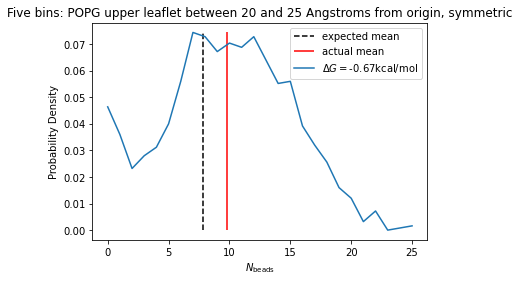

In [14]:
#Part A the four contiguous bins
inner_r = 25
outer_r = 35
ntheta = 2
areaA = get_area(inner_r, outer_r, dth, ntheta)
large_shell = get_shell(the_data, inner_r, outer_r, frames, Ntheta, dr)
theta_A = np.sum([large_shell[:,4:30:6], small_shell[:,4:30:6]], axis=0)


#Part B, the one extra bin
inner_r = 20
outer_r = 25
ntheta = 1
areaB = get_area(inner_r, outer_r, dth, ntheta)
small_shell = get_shell(the_data, inner_r, outer_r, frames, Ntheta, dr)
theta_B = large_shell[:,5:30:6]


#aggregate:
site = theta_A+theta_B
site_area = areaA+areaB


densities, Nexpected, experimental_mean = get_site_stats(site, site_area, exrho)
fig, ax = plot_density(densities, Nexpected, experimental_mean, inner_r, outer_r)
ax.set_title(f"Five bins: {lipid} {leaf}er leaflet between {inner_r} and {outer_r} Angstroms from origin, symmetric")

plt.savefig(f"five_bins_symmetric_{lipid}_{leaf}.pdf")